## Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, mean_absolute_percentage_error

2024-09-25 20:27:57.806561: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-25 20:27:57.849896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-25 20:27:57.849911: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Caminhos utilizados no fluxo

In [3]:
input_path = '/home/murilo/workspace/tcc/tcc/python_model/database/x_test.csv'
output_path = '/home/murilo/workspace/tcc/tcc/python_model/database/y_test.csv'

model_paths = {
    'Quantizado (inteiro completo)': 'model_full_integer_quantized.tflite',
    'Quantizado (apenas pesos)': 'model_weights_only_quantized.tflite',
    'Quantizado (faixa dinâmica)': 'model_dynamic_range_quantized.tflite',
    'Quantizado (float 16)' : 'model_float16_quantized.tflite',
    'Quantizado (float32)': 'model_float32.tflite',
    'Modelo Keras' : 'python_model.h5',
}

## Base de dados para teste

In [4]:
import numpy as np
import pandas as pd

def desnormalize(value, mean, scale):
    value = value * scale + mean                        
    return np.expm1(value)

mean_sodio, scale_sodio = 2.0841135541357527, 0.54462804093762
mean_potassio, scale_potassio = 1.5888672049282762, 0.47844564993241423
mean_cloro, scale_cloro = 2.7378255142446153, 0.504330768563497

In [5]:
x_test = pd.read_csv(input_path).to_numpy()
y_test = pd.read_csv(output_path).to_numpy()

# y_test = desnormalize(y_test, mean_cloro, scale_cloro)

## Volumentria dos arquivos

In [6]:
model_sizes = {name: os.path.getsize(path) for name, path in model_paths.items()}
model_sizes

{'Quantizado (inteiro completo)': 11512,
 'Quantizado (apenas pesos)': 12184,
 'Quantizado (faixa dinâmica)': 12184,
 'Quantizado (float 16)': 20176,
 'Quantizado (float32)': 36676,
 'Modelo Keras': 137112}

/tmp/ipykernel_7953/3531564480.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Model', y='Size (KB)', data=data, ax=ax1, palette=palette, edgecolor='black')


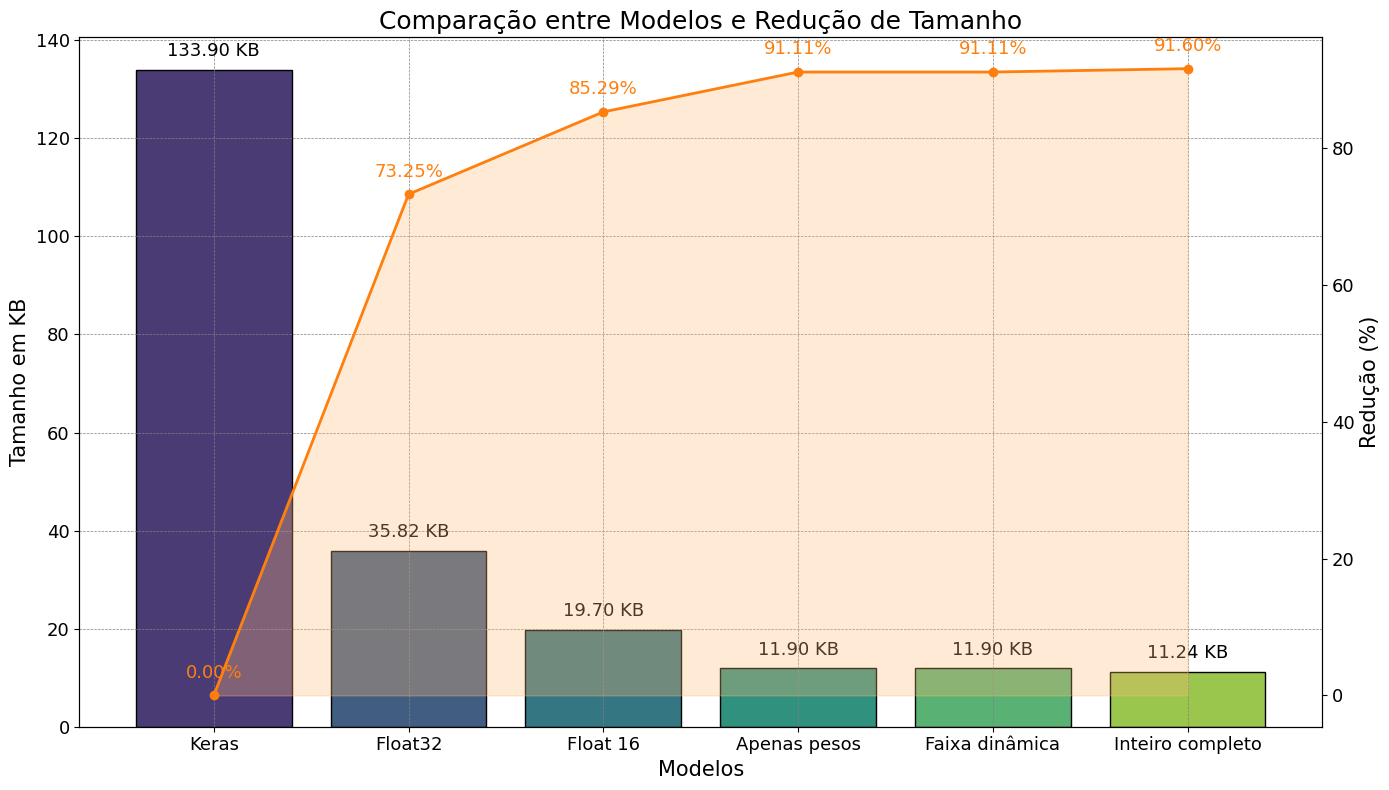

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dados fictícios (substitua com os reais)
model_sizes = {'Keras': 137112, 'Float32': 36676, 'Float 16': 20176, 'Apenas pesos': 12184, 'Faixa dinâmica': 12184, 'Inteiro completo': 11512}
data = pd.DataFrame(list(model_sizes.items()), columns=['Model', 'Size (Bytes)'])
data['Size (KB)'] = data['Size (Bytes)'] / 1024
data['Reduction (%)'] = 100 - (data['Size (KB)'] / data['Size (KB)'].iloc[0] * 100)  # Comparação com o modelo base (Keras)

# Criação da figura
fig, ax1 = plt.subplots(figsize=(14, 8))

# Paleta de cores: "viridis"
palette = sns.color_palette("viridis", len(data))

# Plotando o gráfico de barras com bordas
bars = sns.barplot(x='Model', y='Size (KB)', data=data, ax=ax1, palette=palette, edgecolor='black')

# Adicionando rótulos e títulos com fonte aumentada
ax1.set_xlabel('Modelos', fontsize=15, color='black')
ax1.set_ylabel('Tamanho em KB', fontsize=15, color='black')
ax1.tick_params(axis='y', labelsize=13, labelcolor='black')
ax1.tick_params(axis='x', labelsize=13, labelcolor='black')
ax1.set_title('Comparação entre Modelos e Redução de Tamanho', fontsize=18, color='black')

# Adicionando os valores nas barras
for index, value in enumerate(data['Size (KB)']):
    ax1.text(index, value + 2, f"{value:.2f} KB", ha='center', va='bottom', color='black', fontsize=13)

# Criando um segundo eixo y para a porcentagem de redução
ax2 = ax1.twinx()
ax2.plot(data['Model'], data['Reduction (%)'], color='#ff7f0e', marker='o', linewidth=2)
ax2.fill_between(data['Model'], data['Reduction (%)'], color='#ffbb78', alpha=0.3)  # Preenchimento sob a curva
ax2.set_ylabel('Redução (%)', fontsize=15, color='black')
ax2.tick_params(axis='y', labelsize=13, labelcolor='black')

# Adicionando os valores de redução acima da linha
for index, value in enumerate(data['Reduction (%)']):
    ax2.text(index, value + 2, f"{value:.2f}%", ha='center', va='bottom', color='#ff7f0e', fontsize=13)

# Grid para clareza
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

# Melhorar o espaçamento da visualização
fig.tight_layout()

plt.show()

## Carregando os modelos

### Modelos TFlite

In [43]:
models = {
    'Quantizado (inteiro completo)': 'model_full_integer_quantized.tflite',
    'Quantizado (apenas pesos)': 'model_weights_only_quantized.tflite',
    'Quantizado (faixa dinâmica)': 'model_dynamic_range_quantized.tflite',
    'Quantizado (float 16)' : 'model_float16_quantized.tflite',
    'Quantizado (float32)': 'model_float32.tflite',
}

interpreters = {}
for key, path in models.items():
    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    interpreters[key] = interpreter

### Modelo Keras

In [44]:
interpreters['Keras'] = tf.keras.models.load_model("python_model.h5")

In [45]:
interpreters

{'Quantizado (inteiro completo)': <tensorflow.lite.python.interpreter.Interpreter at 0x7f148c22c610>,
 'Quantizado (apenas pesos)': <tensorflow.lite.python.interpreter.Interpreter at 0x7f148c22fee0>,
 'Quantizado (faixa dinâmica)': <tensorflow.lite.python.interpreter.Interpreter at 0x7f148c22e620>,
 'Quantizado (float 16)': <tensorflow.lite.python.interpreter.Interpreter at 0x7f148c22dba0>,
 'Quantizado (float32)': <tensorflow.lite.python.interpreter.Interpreter at 0x7f148c22ce20>,
 'Keras': <keras.engine.sequential.Sequential at 0x7f148c2a4be0>}

## Tempo de execução

In [46]:
def predict_tflite(model, test_data):
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    predictions = []

    input_type = input_details[0]['dtype']

    for example in test_data:
        test_example = np.expand_dims(example, axis=0).astype(input_type)
        model.set_tensor(input_details[0]['index'], test_example)
        model.invoke()
        output_data = model.get_tensor(output_details[0]['index'])
        predictions.append(output_data)
        
    return np.array(predictions)

inference_times = {name: [] for name in interpreters}
inferences = {name: [] for name in interpreters}

for name, model in interpreters.items():
    for _ in range(100):
        start_time = time.time()
        if 'Quantizado' in name:
            predictions = predict_tflite(model, x_test)
        else:
            predictions = model.predict(x_test)
        end_time = time.time()
        inference_times[name].append(end_time - start_time)

2/2 [==============================] - 0s 2ms/step


In [47]:
for name, times in inference_times.items():
    print(f"{name}:")
    print(f"  Média do Tempo de Inferência: {np.mean(times):.4f} segundos")
    print(f"  Mediana do Tempo de Inferência: {np.median(times):.4f} segundos")
    print(f"  Desvio Padrão: {np.std(times):.4f} segundos")
    print(f"  Máximo: {np.max(times):.4f} segundos")
    print(f"  Mínimo: {np.min(times):.4f} segundos")
    print()

Quantizado (inteiro completo):
  Média do Tempo de Inferência: 0.0007 segundos
  Mediana do Tempo de Inferência: 0.0006 segundos
  Desvio Padrão: 0.0002 segundos
  Máximo: 0.0013 segundos
  Mínimo: 0.0005 segundos

Quantizado (apenas pesos):
  Média do Tempo de Inferência: 0.0004 segundos
  Mediana do Tempo de Inferência: 0.0004 segundos
  Desvio Padrão: 0.0001 segundos
  Máximo: 0.0008 segundos
  Mínimo: 0.0003 segundos

Quantizado (faixa dinâmica):
  Média do Tempo de Inferência: 0.0003 segundos
  Mediana do Tempo de Inferência: 0.0003 segundos
  Desvio Padrão: 0.0001 segundos
  Máximo: 0.0007 segundos
  Mínimo: 0.0003 segundos

Quantizado (float 16):
  Média do Tempo de Inferência: 0.0004 segundos
  Mediana do Tempo de Inferência: 0.0003 segundos
  Desvio Padrão: 0.0001 segundos
  Máximo: 0.0007 segundos
  Mínimo: 0.0003 segundos

Quantizado (float32):
  Média do Tempo de Inferência: 0.0004 segundos
  Mediana do Tempo de Inferência: 0.0003 segundos
  Desvio Padrão: 0.0001 segundos
 

## Métricas de erro

In [48]:
def predict_tflite(model, test_data):
    input_details = model.get_input_details()
    output_details = model.get_output_details()
    predictions = []

    input_type = input_details[0]['dtype']
    
    for example in test_data:
        test_example = np.expand_dims(example, axis=0).astype(input_type)
        model.set_tensor(input_details[0]['index'], test_example)
        model.invoke()
        output_data = model.get_tensor(output_details[0]['index'])
        predictions.append(output_data[0][0])
    return np.array(predictions)

predictions_dict = {}
for name, model in interpreters.items():
    if 'Quantizado' in name:
        predictions_dict[name] = predict_tflite(model, x_test)
    else:
        predictions_dict[name] = model.predict(x_test).flatten()

2/2 [==============================] - 0s 2ms/step


In [49]:
metrics_dict = {}
for name, predictions in predictions_dict.items():
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    medae = median_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)

    metrics_dict[name] = {
        'MSE': mse,
        'RMSE': rmse, 
        'MAE': mae,
        'R2': r2,
        'MEDAE': medae,
        'MAPE': mape
    }

In [50]:
for name, metrics in metrics_dict.items():
    print(f"Resultados para o modelo {name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.5f}")
    print()

Resultados para o modelo Quantizado (inteiro completo):
  MSE: 49.06355
  RMSE: 7.00454
  MAE: 6.98162
  R2: -52.48337
  MEDAE: 6.95142
  MAPE: 25.33408

Resultados para o modelo Quantizado (apenas pesos):
  MSE: 0.03422
  RMSE: 0.18498
  MAE: 0.13312
  R2: 0.96270
  MEDAE: 0.09979
  MAPE: 0.39127

Resultados para o modelo Quantizado (faixa dinâmica):
  MSE: 0.03422
  RMSE: 0.18498
  MAE: 0.13312
  R2: 0.96270
  MEDAE: 0.09979
  MAPE: 0.39127

Resultados para o modelo Quantizado (float 16):
  MSE: 0.03407
  RMSE: 0.18458
  MAE: 0.13253
  R2: 0.96286
  MEDAE: 0.09860
  MAPE: 0.38685

Resultados para o modelo Quantizado (float32):
  MSE: 0.03407
  RMSE: 0.18458
  MAE: 0.13254
  R2: 0.96286
  MEDAE: 0.09869
  MAPE: 0.38704

Resultados para o modelo Keras:
  MSE: 0.03407
  RMSE: 0.18458
  MAE: 0.13254
  R2: 0.96286
  MEDAE: 0.09869
  MAPE: 0.38704



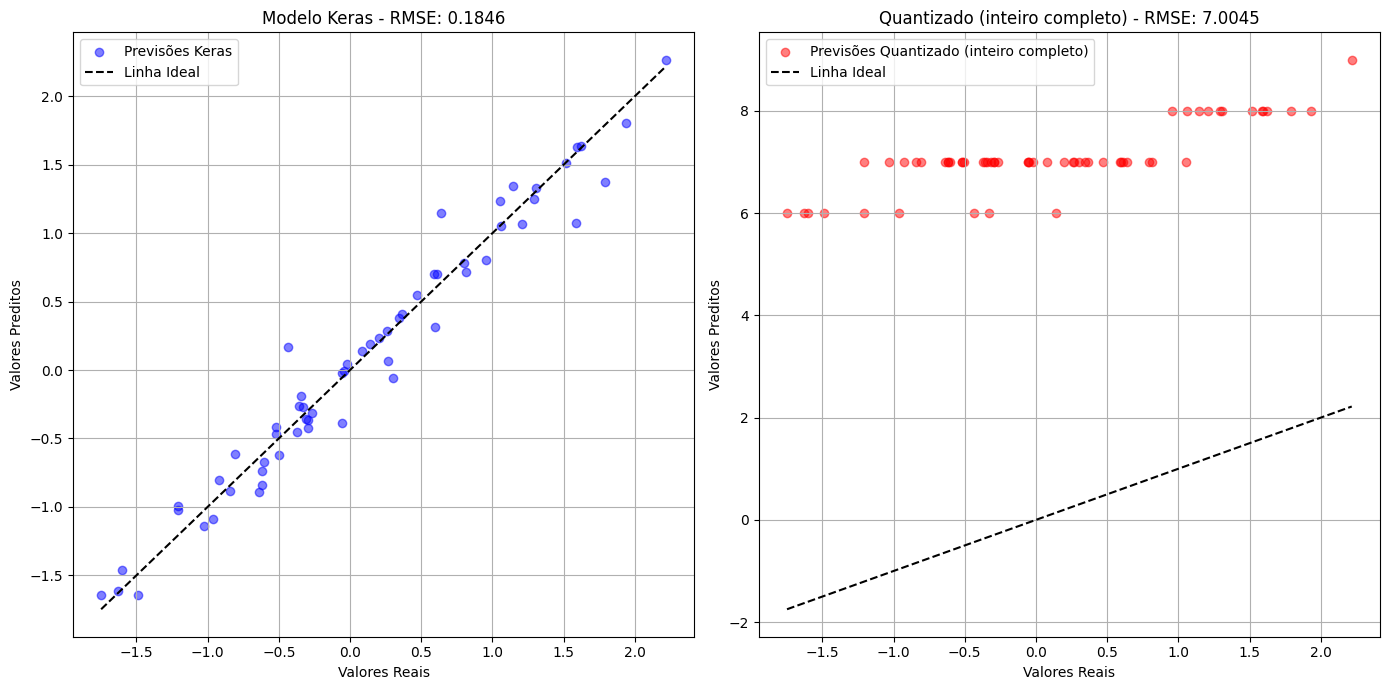

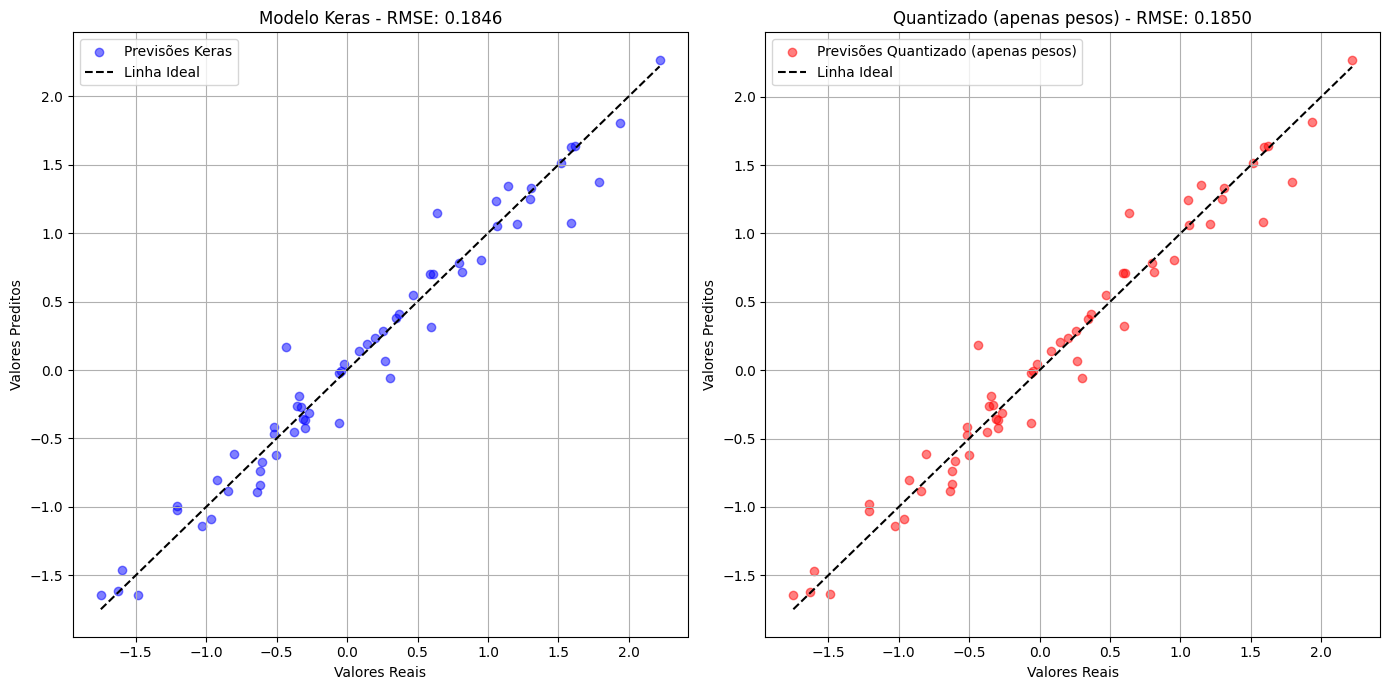

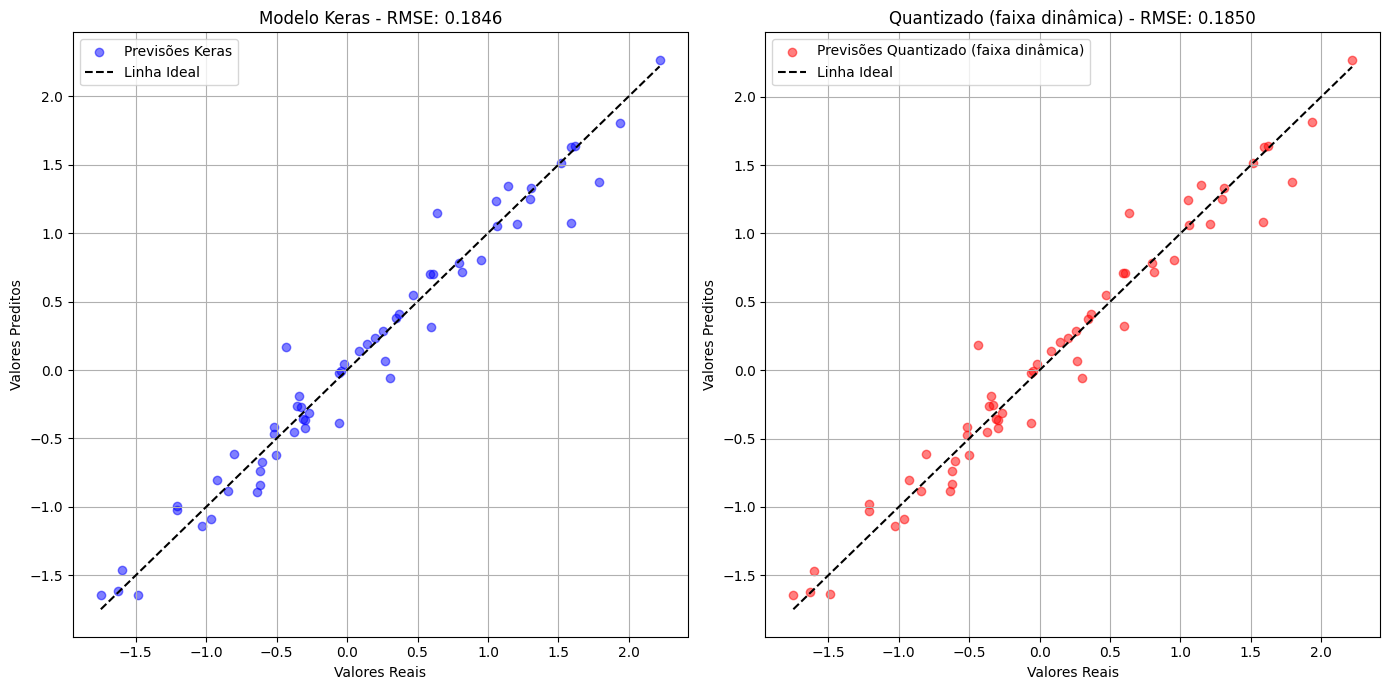

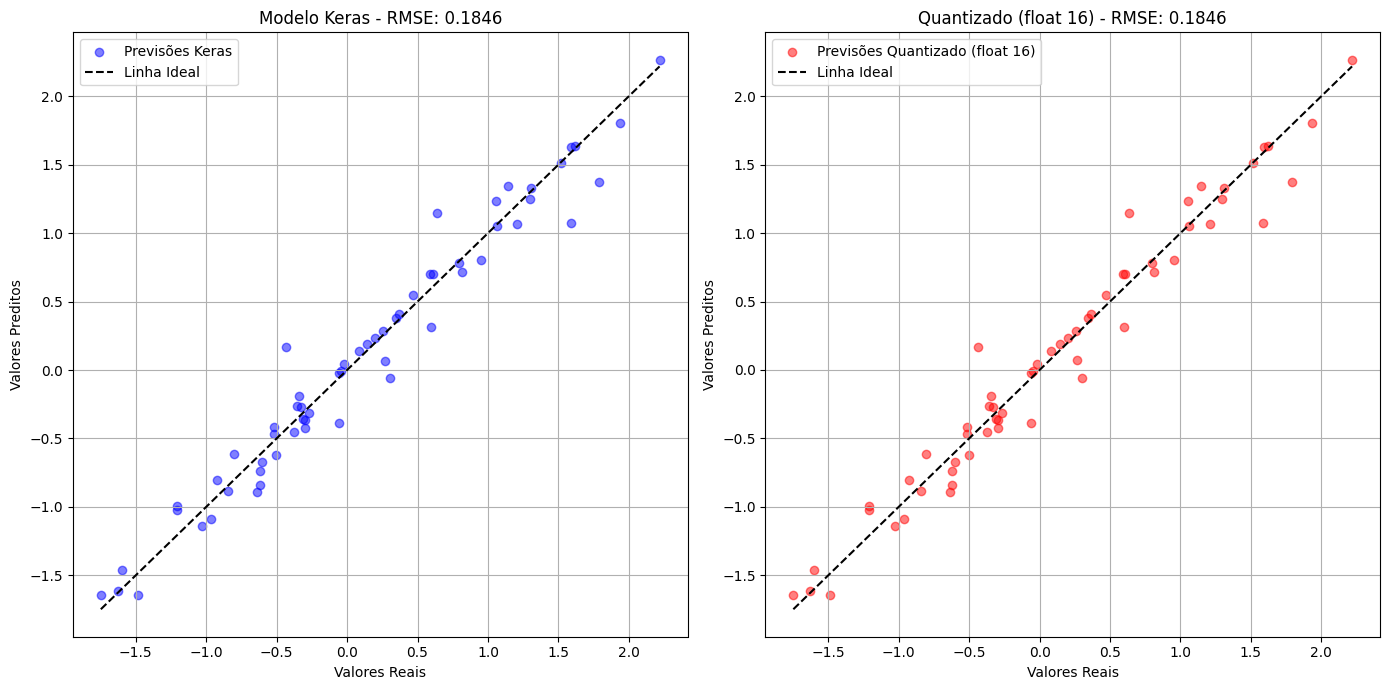

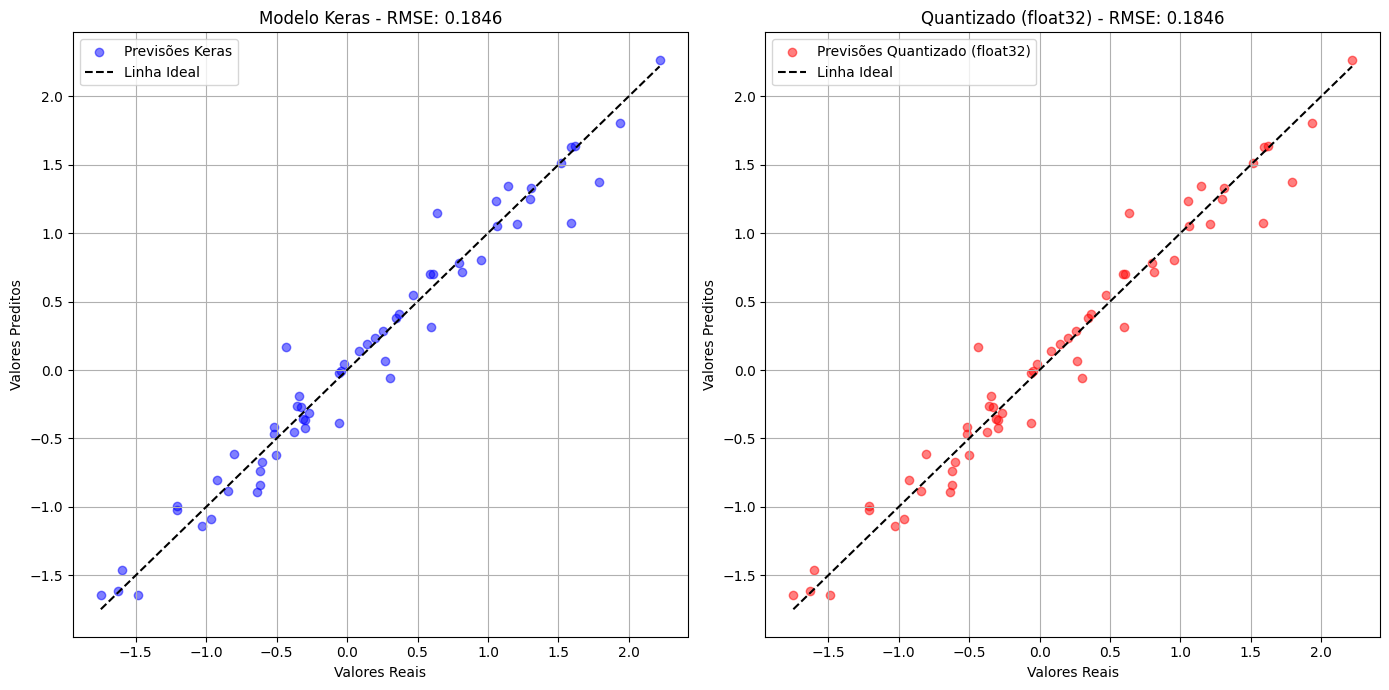

In [51]:
model_names = [name for name in predictions_dict if 'Quantizado' in name]

for name in model_names:
    plt.figure(figsize=(14, 7))

    # Gráfico para o modelo Keras
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, predictions_dict['Keras'], color='blue', alpha=0.5, label='Previsões Keras')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Linha Ideal')
    plt.title(f'Modelo Keras - RMSE: {metrics_dict["Keras"]["RMSE"]:.4f}')
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Preditos')
    plt.grid()
    plt.legend()

    # Gráfico para o modelo quantizado atual
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, predictions_dict[name], color='red', alpha=0.5, label=f'Previsões {name}')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Linha Ideal')
    plt.title(f'{name} - RMSE: {metrics_dict[name]["RMSE"]:.4f}')
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Preditos')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

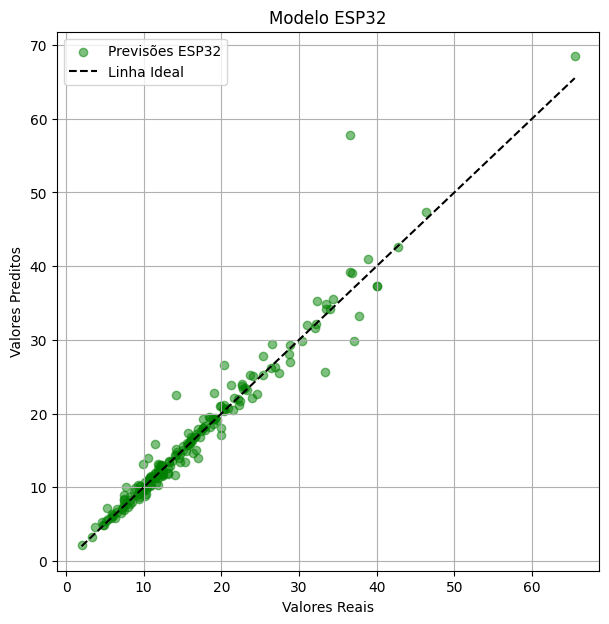

In [8]:
valores_saida = pd.read_csv('/home/murilo/workspace/tcc/tcc/utils/valores_saida.csv')
saida = pd.read_csv('/home/murilo/workspace/tcc/tcc/python_model/database/saida.csv')

predicted_cl = valores_saida['Cl']
real_cl = saida['Cl']

# Atualizando o gráfico com as alterações solicitadas
plt.figure(figsize=(7, 7))  # Mantendo o tamanho do gráfico em 7x7
plt.scatter(real_cl, predicted_cl, color='green', alpha=0.5, label='Previsões ESP32', marker='o')
plt.plot([real_cl.min(), real_cl.max()], [real_cl.min(), real_cl.max()], 'k--', label='Linha Ideal')
plt.title('Modelo ESP32')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.grid(True)  # Ativação da grade no gráfico
plt.legend()
plt.show()

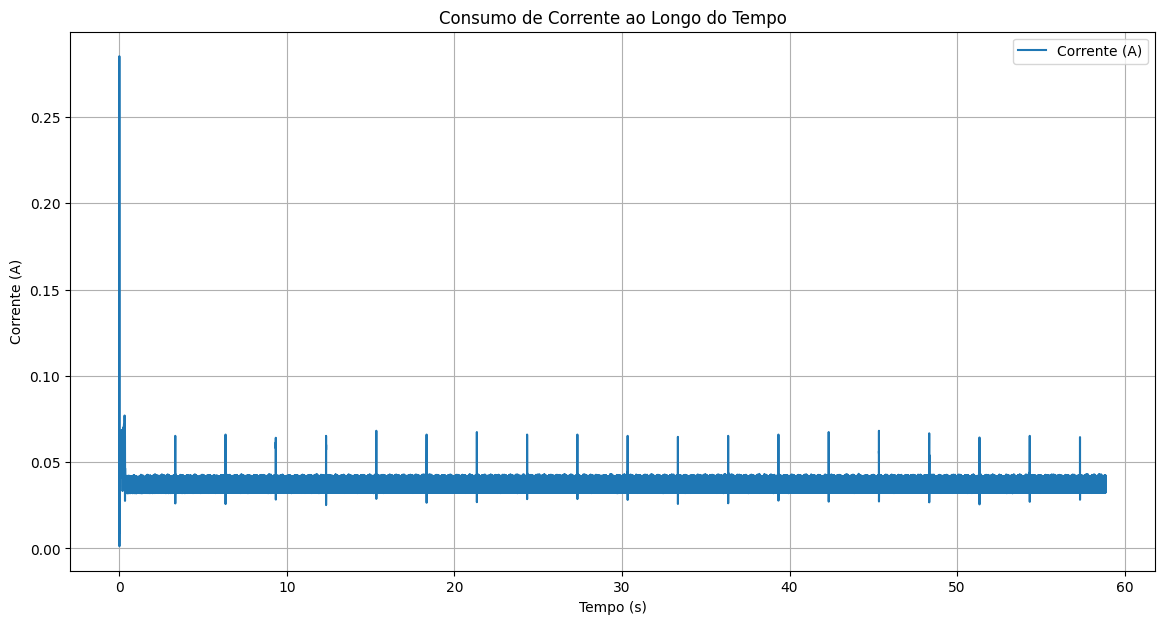

In [16]:
consumo_df = pd.read_csv('/home/murilo/workspace/tcc/tcc/utils/consumo.csv')
consumo_df_filtered = consumo_df.iloc[87951:].reset_index(drop=True)

consumo_df_filtered['Corrente(A)'] = consumo_df_filtered['Current(uA)'] / 1000000
consumption_stats_filtered = consumo_df_filtered['Corrente(A)'].agg(['min', 'max', 'mean'])

consumo_df_filtered['Adjusted Time(s)'] = (consumo_df_filtered['Timestamp(ms)'] - 879.51) / 1000

plt.figure(figsize=(14, 7))
plt.plot(consumo_df_filtered['Adjusted Time(s)'], consumo_df_filtered['Corrente(A)'], label='Corrente (A)')
plt.title('Consumo de Corrente ao Longo do Tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Corrente (A)')
plt.legend()
plt.grid(True)
plt.show()

### O modelo quantizado utilizado float 32 manteve a precisão mais próxima do modelo real.

## Detalhe do modelo Float 32

In [54]:
model = interpreters['Quantizado (float32)']

input_details = model.get_input_details()
print("Detalhes do Tensor de Entrada:", input_details)

output_details = model.get_output_details()
print("Detalhes do Tensor de Saída:", output_details)

Detalhes do Tensor de Entrada: [{'name': 'serving_default_dense_3_input:0', 'index': 0, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Detalhes do Tensor de Saída: [{'name': 'StatefulPartitionedCall:0', 'index': 9, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


## Criação do array de bytes para o Embarque na ESP32

In [55]:
tflite_model_file = 'model_float32.tflite'

# Conteúdo do arquivo model.h
header_content = """
#ifndef MODEL_H_
#define MODEL_H_

extern const unsigned char model[];
extern const int model_len;

#endif  // MODEL_H_
"""

# Escreve o conteúdo no arquivo model.h
with open("model.h", "w") as file:
    file.write(header_content.strip())

with open(tflite_model_file, 'rb') as f:
    tflite_model_content = f.read()

with open("model.cc", "w") as f:
    f.write("const unsigned char model[] = {\n    ")
    for i, byte in enumerate(tflite_model_content):
        f.write(f"0x{byte:02x}, ")
        if (i + 1) % 12 == 0:
            f.write("\n    ")
    f.write("\n};\n")
    f.write(f"const int model_len = {len(tflite_model_content)};")